# Unet Satcen Finetuning

Fine tune the Unet model trained on the Airbus dataset using the Satcen dataset.

## Split the Dataset

Load and split the *full* Satcen dataset into **60-20-20 stratified** train, validation and test sets. Save the files in the *satcen_dataset/full/splits/x* (where x: {'train', 'validation', 'test'}) folders.

In [1]:
import os
import pathlib
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import numpy as np
import ijson
import json
from sklearn.model_selection import train_test_split
import shutil
from fastai.vision.all import *
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# path to satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/full').resolve()

# path to original satcen dataset
satcen_path_original = pathlib.Path('../satcen_dataset/original').resolve()

### Load the Data

Load all Satcen images with their annotations (bounding boxes) and convert the annotations to binary labels for future use.

In [2]:
# load the full Satcen dataset
satcen = os.listdir(satcen_path/'pictures')

# load the labels (bounding boxes)
labels_file = open(satcen_path/'labels.json')
labels_json = json.load(labels_file)

# conver the bounding boxes into binary labels 0/1
y = np.array([])
for img in satcen:

    bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']
    y = np.append(y, 1 if len(bounding_boxes) > 0 else 0)

# print info about entire dataset
print(f'Total number of Satcen images: {len(satcen)}')
print(f'Total number of labels (annotations): {len(labels_json)}')
print(f'Number of positive observations: {np.sum(y==1)} ({100 * np.sum(y==1) / len(y):.2f}%)')
print(f'Number of negative observations: {np.sum(y==0)} ({100 * np.sum(y==0) / len(y):.2f}%)')

Total number of Satcen images: 9420
Total number of labels (annotations): 9420
Number of positive observations: 1525 (16.19%)
Number of negative observations: 7895 (83.81%)


### Split the Data

Perform a stratified split over the data into train, validation and test sets and save the images (**DONE ONCE**) in the corresponding folders.

In [4]:
# # make the splits
# train_images, test_valid_images, y_train, y_test_valid = train_test_split(satcen, y, test_size=0.4, stratify=y, random_state=27)
# valid_images, test_images, y_valid, y_test = train_test_split(test_valid_images, y_test_valid, test_size=0.5, stratify=y_test_valid, random_state=27)

# # print stats about the splits
# print('Train dataset')
# print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
# print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

# print('\nValidation dataset')
# print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
# print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

# print('\nTest dataset')
# print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
# print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

# # copy the training images
# for img in train_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/train/images'/img
#     shutil.copy(src, dst)

# # copy the validation images
# for img in valid_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/validation/images'/img
#     shutil.copy(src, dst)

# # copy the test images
# for img in test_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/test/images'/img
#     shutil.copy(src, dst)

print(f'\nSize of train folder: {len(os.listdir(satcen_path/"splits/train/images"))}')
print(f'Size of train folder: {len(os.listdir(satcen_path/"splits/validation/images"))}')
print(f'Size of train folder: {len(os.listdir(satcen_path/"splits/test/images"))}')


Size of train folder: 5652
Size of train folder: 1884
Size of train folder: 1884


### Load the Split Data

Load the train, validation and test data from their corresponding folders. 
Compute the binary labels for each set.

In [6]:
# load the data
train_images = os.listdir(satcen_path/'splits/train/images')
valid_images = os.listdir(satcen_path/'splits/validation/images')
test_images = os.listdir(satcen_path/'splits/test/images')

# compute binary labels for each set
y_train = np.array([y[satcen.index(img)] for img in train_images])
y_valid = np.array([y[satcen.index(img)] for img in valid_images])
y_test = np.array([y[satcen.index(img)] for img in test_images])

# print stats about the splits
print('Train dataset')
print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

print('\nValidation dataset')
print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

print('\nTest dataset')
print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

Train dataset
Size: 5652 (60.00%)
Positive observations: 915 (16.19%)
Negative observations: 4737 (83.81%)

Validation dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)

Test dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)


## Generate Ground Truth Labels

Compute ground truth for images in the Satcen dataset based on the given bounding boxes.
Ground truth labels should be saved as *.png* files in the *satcen_dataset/ground_truth_masks* folder. Files should have _L at the end of the filename.

In each ground truth image:
- 0 pixel value represents background pixel
- 1 pixel value represents ship pixel

In [7]:
# compute segmentation mask of a Satcen image based on its bounding box
# @param img_name - filename of the image for which to compute ground truth
# @param bounding_boxes - list of bounding boxes for that image
# @param save - whether or not to save the mask
# @param path - where to save the mask
# @return mask - PIL image representing the mask of the given image
def get_image_mask_satcen(img_name, bounding_boxes, path, save = False):
    
    # create the skeleton of the segmentation mask
    # size is constant for satcen dataset, 256 x 256
    mask = Image.fromarray(np.zeros((256, 256)), 'P')

    # get a drawer object
    draw = Drawer.Draw(mask)

    # loop through the bounding boxes
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw the bounding box on the image
        draw.polygon(coords, fill=1)

    if save:
        mask.save(path/f'{img_name[:-4]}_L.png')

    return mask

# function that generates and saves masks for Satcen images
# @param path - where to save the masks
def save_all_satcen_masks(path):

    # delete all the files in the target directory
    for f in os.listdir(path):
        os.remove(path/f)

    # loop through all satcen images
    for img in satcen:

        # get the corresponding list of bounding boxes
        bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']

        # generate and save mask
        get_image_mask_satcen(img, bounding_boxes, path, save=True)

# save_all_satcen_masks(satcen_path/'ground_truth_masks')

### Show a Few Examples

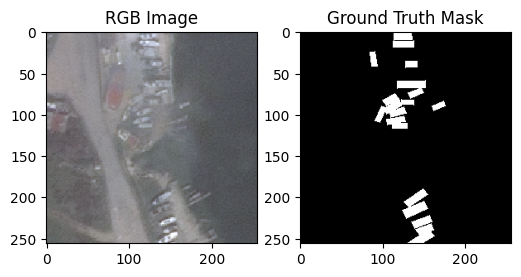

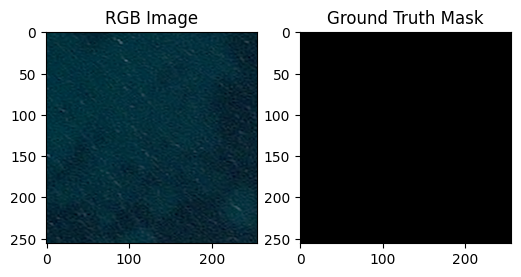

In [10]:
# get one image that contains ships and one that does not
ship_img = satcen[np.where(y==1)[0][0]]
no_ship_img = satcen[np.where(y==0)[0][1]]

# show images and ground truth
fig = plt.subplots(1, 2, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

fig = plt.subplots(1, 2, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/no_ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{no_ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

## Fine Tuning

### Construct the Model

Construct the model in the same way as the original one trained on the Airbus dataset. Load the weights of the Airbus model.

Save the model as *unet_satcen_finetuned.pth* in the *ship_detection/models* folder.

DynamicUnet (Input shape: 4 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 64 x 64   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 32 x 32   
MaxPool2d                                   

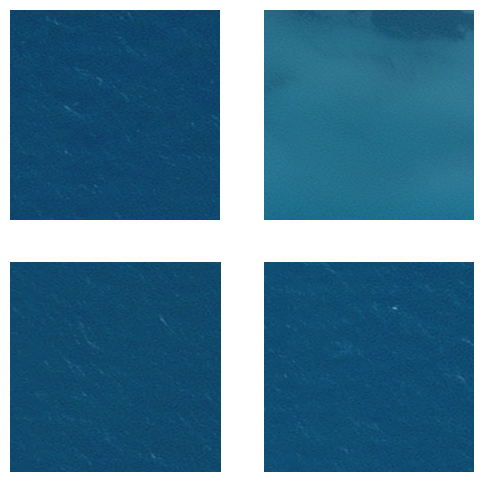

In [27]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'ground_truth_masks'/f'{fn.stem}_L.png'

# create a datablock
dblock = DataBlock( 
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation')
)

# load the data in the datablock
dataset = dblock.datasets(satcen_path/'splits/')
dls = dblock.dataloaders(satcen_path/'splits/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=12)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4,
    metrics=[JaccardCoeff()]
)

# load the model
unet.load('unet_googlenet')

# print model architecture
unet.summary()

### Train the Model

Train using the same approach as the original model, then save the model.

In [28]:
# train the model
unet.fine_tune(4, freeze_epochs=3)

# save the model
print('Saving model...')
unet.save('unet_satcen_finetuned')
print('Saved model')

epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.004921,0.004189,0.644534,19:08
1,0.003507,0.004008,0.681004,19:09
2,0.002647,0.003311,0.720505,19:10
3,0.002257,0.003169,0.720218,19:09


Saving model...
Saved model


## Testing

Test the fine-tuned model on the remainder of the Satcen dataset. 

### Construct the Test Set

In [8]:
satcen_test = list(set(satcen) - set(os.listdir(satcen_path/'train_pictures')))
y_test = np.array(y)[[satcen.index(e) for e in satcen_test]]

print('Size of test set:', len(satcen_test))

test_p = np.sum(y_test == 1)
test_n = np.sum(y_test == 0)

print(f'Positive test examples: {test_p} ({test_p / len(satcen_test)}%)')
print(f'Negative test examples: {test_n} ({test_n / len(satcen_test)}%)')

# # sanity check
# for i in range(len(satcen_test)):

#     img = satcen_test[i]
#     mask = np.array(Image.open(satcen_path/'labeled_images_binary'/f'{img[:-4]}_L.png'))

#     if (np.any(mask == 1) and y_test[i] == 0) or (not np.any(mask == 1) and y_test[i] == 1):
#         raise Exception('Labels do not correspond for ' + img)

Size of test set: 550
Positive test examples: 458 (0.8327272727272728%)
Negative test examples: 92 (0.16727272727272727%)


### Load the model

Load the fine-tuned U-net model.

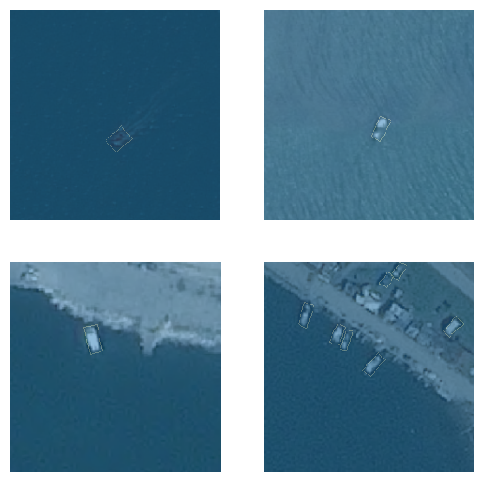

In [12]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'labeled_images_binary'/f'{fn.stem}.png'

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    item_tfms=Resize(224) # resize images to 224x224
)

# load the data in the datablock
torch.cuda.init()
dls = dblock.dataloaders(satcen_path/'train_pictures/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=4)

# create the learner
unet_finetuned = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet_finetuned.load('unet_satcen_finetuned')

### Evaluate Model

Plot ROC and PR curves for the model.

For each test image, compute a decision score (*z* array) representing the maximum value in the raw U-net output. Compare the decision scores against the threshold to determine the type of prediction.

In [107]:
# compute and save decision scores
z = []
for img in satcen_test:

    # generate prediction
    with unet_finetuned.no_bar(), unet_finetuned.no_logging(): _, _, pred = unet_finetuned.predict(satcen_path/'pictures'/img)
    z.append(np.max(pred.numpy()[1]))
        

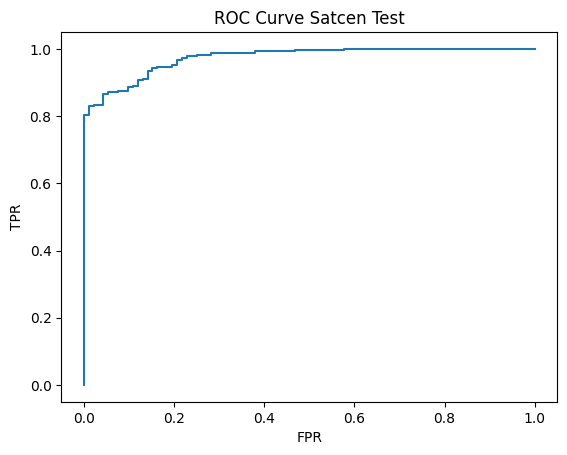

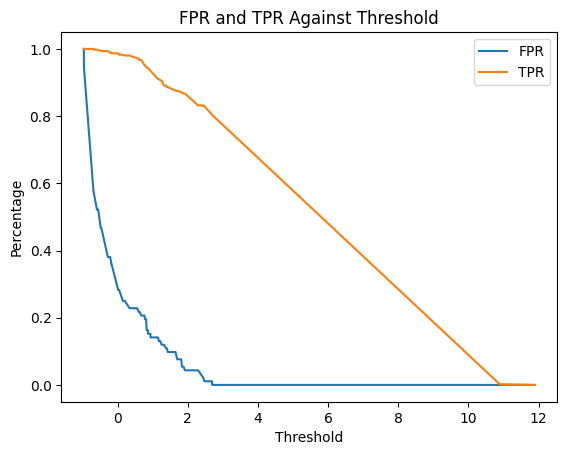

In [108]:
# ROC
fprs, tprs, thresholds = roc_curve(y_test, z)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Satcen Test')
plt.show()

plt.plot(thresholds, fprs, thresholds, tprs)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend(['FPR', 'TPR'])
plt.title('FPR and TPR Against Threshold')
plt.show()

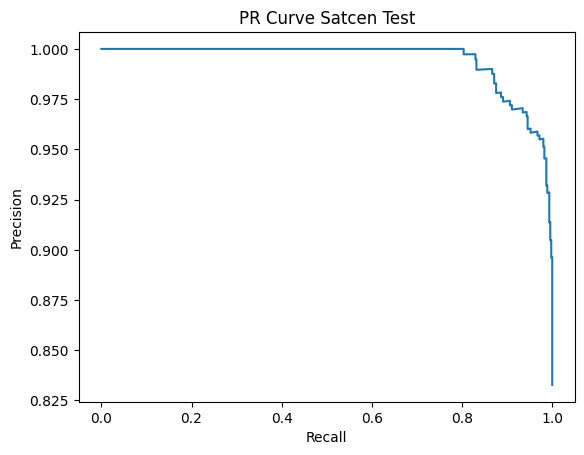

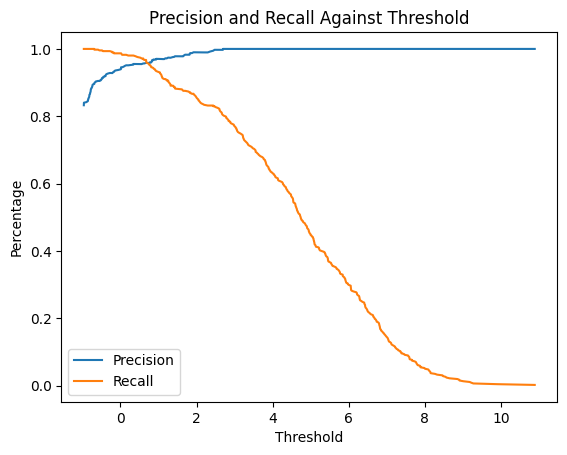

In [109]:
# PR
precisions, recalls, thresholds = precision_recall_curve(y_test, z)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Satcen Test')
plt.show()

thresholds = np.append(thresholds, math.inf)
plt.plot(thresholds, precisions, thresholds, recalls)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision and Recall Against Threshold')
plt.legend(['Precision', 'Recall'])
plt.show()

## Testing on Full Dataset

Test the Unet model on the entire dataset, including the additional images.

Raw outputs of Unet should be saved as *.npy* files in the *satcen_dataset/full/results_unet* folder, with *_unet_out* after the original file name.

### Construct the Test Set

The test set represents the set difference between all images (*satcen_dataset/full/pictures*) and the images used for training (*satcen_dataset/original/train_pictures*). 

Make sure to **remove images that are not annotated**!

In [10]:
# get all images
all_images = os.listdir(satcen_path_full/'pictures')
print(f'Total number of images: {len(all_images)}')

# get training images
train_images = os.listdir(satcen_path/'train_pictures')
print(f'Number of training images: {len(train_images)}')

# construct the test set
test_images = list(set(all_images) - set(train_images))
print(f'Number of test images: {len(test_images)}')

Total number of images: 9420
Number of training images: 1283
Number of test images: 8137


### Construct the Test Labels

Use the *labels.json* file to construct a list representing the class labels of the images in the *test_images* list.

Labels:
- positive: 1
- negative: 0

In [11]:
# open the json
labels_file = open(satcen_path_full/'labels.json')
labels_json = json.load(labels_file)

# filter json to only contain entries for test images
labels_json = list(filter(lambda x: x['name'] in test_images, labels_json))

# map the json to list of binary labels
y = []
for img in test_images:

    bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']
    y.append(1 if len(bounding_boxes) > 0 else 0)

# print test set stats
y = np.array(y)
print('Test set stats')
print(f'Total number of test examples: {len(y)}')
print(f'Number of positive observations: {np.sum(y==1)}')
print(f'Number of negative observations: {np.sum(y==0)}')

Test set stats
Total number of test examples: 8137
Number of positive observations: 458
Number of negative observations: 7679


### Run Unet on Test Examples

Save the results in the *satcen_dataset/full/results_unet* folder as *.npy* files with *_unet_out* after the original filename.

In [13]:
# remove all files in the results_unet folder
for f in os.listdir(satcen_path_full/'results_unet'):
    os.remove(satcen_path_full/'results_unet'/f)

# loop through all images in the test set
for test_img in test_images:

    # generate prediction
    with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(satcen_path_full/'pictures'/test_img)
    pred = pred.numpy()[1]

    # save prediction as .npy
    np.save(satcen_path_full/'results_unet/'f'{test_img[:-4]}_unet_out', pred)

print(f'Number of predictions: {len(os.listdir(satcen_path_full/"results_unet"))}')

Number of predictions: 8137


### Evaluate the Model

Evaluate the Unet model as a binary classifier on the **full Satcen dataset**.

Load raw outputs from the *satcen_dataset/full/results_unet* folder, generate decision scores from the raw outputs and plot the ROC and PR curves.

In [14]:
# decision scores
z = []

# loop through all the test images
for test_img in test_images:

    # load raw output of unet
    raw_unet_output = np.load(satcen_path_full/'results_unet'/f'{test_img[:-4]}_unet_out.npy')
    dec_score = np.max(raw_unet_output)

    # store decision score
    z.append(dec_score)

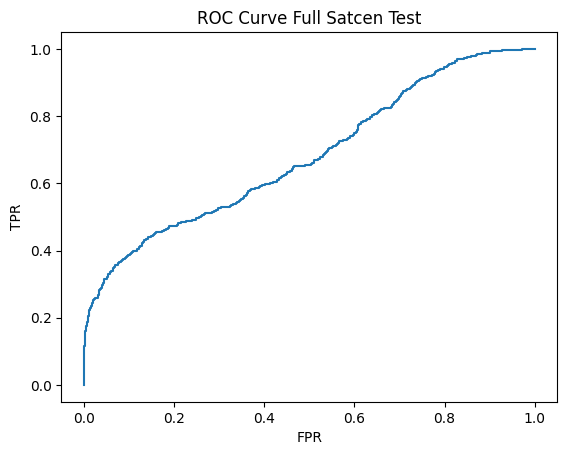

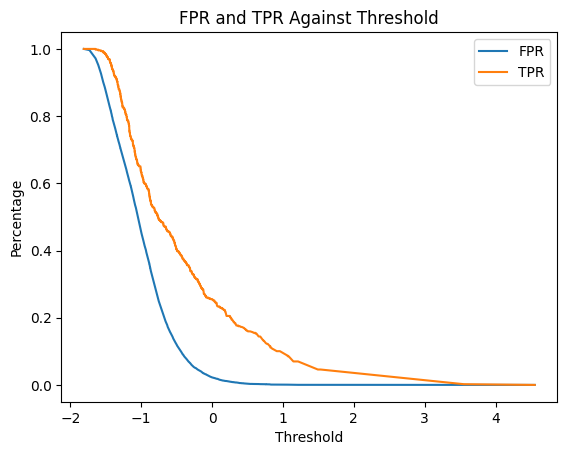

In [15]:
# ROC
fprs, tprs, thresholds = roc_curve(y, z)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Full Satcen Test')
plt.show()

plt.plot(thresholds, fprs, thresholds, tprs)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend(['FPR', 'TPR'])
plt.title('FPR and TPR Against Threshold')
plt.show()

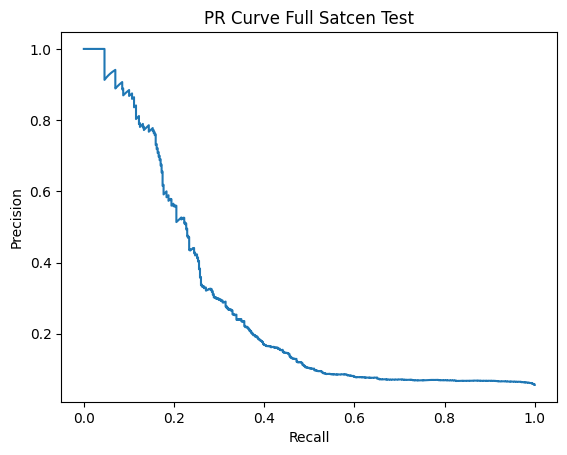

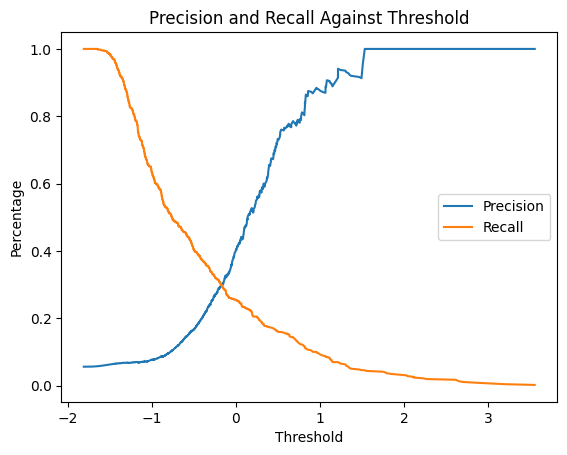

In [16]:
# PR
precisions, recalls, thresholds = precision_recall_curve(y, z)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Full Satcen Test')
plt.show()

thresholds = np.append(thresholds, math.inf)
plt.plot(thresholds, precisions, thresholds, recalls)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision and Recall Against Threshold')
plt.legend(['Precision', 'Recall'])
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

output = np.load('../satcen_dataset/full/results_unet/chip13056-19712_unet_out.png')
plt.imshow(output)

FileNotFoundError: [Errno 2] No such file or directory: '../satcen_dataset/full/results_unet/chip13056-19712_unet_out.png'

3 runs of bootstrap 